### Step 1: Explore and Filter Relevant Categories
- Load the `det_train.json` file from BDD100K.
- Print and inspect all available object categories.
- Choose the categories relevant to project:
    - Point features: e.g. road surface markings, traffic lights
    - Linear features: e.g. lane markings (handled separately)

In [ ]:
import json

label_path = "./Data/labels/det_20/det_train.json"

# Load the annotation JSON
with open(label_path, "r") as f:
    data = json.load(f)

# Collect all unique categories
all_categories = set()
for item in data:
    for obj in item.get('labels',[]):
        all_categories.add(obj['category'])

# Print sorted categories
print("Unique categories found in BDD100K detection annotations:")
for idx, cat in enumerate(sorted(all_categories)):
    print(f"{idx+1:2d}. {cat}")

| No. | Category        | Usefulness for MVP | Type                                |
|-----|------------------|--------------------|-------------------------------------|
| 1   | bicycle          | No              | Not useful for map extraction       |
| 2   | bus              | Optional        | Large vehicle, may aid context      |
| 3   | car              | Yes             | Common traffic object               |
| 4   | motorcycle       | No              | Not relevant to static map features |
| 5   | other person     | No              | Dynamic/human — not useful          |
| 6   | other vehicle    | Optional        | Contextual, not priority            |
| 7   | pedestrian       | No              | Dynamic object                      |
| 8   | rider            | No              | Person-related, not relevant        |
| 9   | traffic light    | Yes             | Point feature (RSM-like)            |
|10   | traffic sign     | Yes             | Point feature (map annotation)      |
|11   | trailer          | Optional        | Same as truck — context only        |
|12   | train            | No              | Rare, not useful for road maps      |
|13   | truck            | Optional        | Large vehicle, possible context     |


In [ ]:
from collections import defaultdict

# Dictionary to collect unique values per attribute key
attribute_values = defaultdict(set)

# Loop through each item and collect values
for item in data:
    attributes = item.get('attributes', {})
    for key, value in attributes.items():
        attribute_values[key].add(value)

# Print results
print("\nUnique values for each 'attributes' key:")
for attr_key, values in attribute_values.items():
    print(f"- {attr_key}: {sorted(values)}")

In [ ]:
df = pd.read_json(label_path)

In [ ]:
df.head(5)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# ---- 1. Histogram: Number of Labels per Image ----
num_labels_per_image = [len(item.get("labels", [])) for item in data]

plt.figure(figsize=(10, 5))
plt.hist(num_labels_per_image, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Number of Labels per Image")
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# ---- 2. Bar Chart: Top 20 Object Categories ----
category_counter = Counter()
for item in data:
    for label in item.get("labels", []):
        category_counter[label["category"]] += 1

plt.figure(figsize=(12, 6))
cat_names, cat_counts = zip(*category_counter.most_common(20))
plt.bar(cat_names, cat_counts)
plt.title("Top Object Categories")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# ---- 3. Bar Charts for Contextual Attributes ----
weather_counter = Counter()
scene_counter = Counter()
timeofday_counter = Counter()

for item in data:
    attr = item.get("attributes", {})
    weather_counter[attr.get("weather")] += 1
    scene_counter[attr.get("scene")] += 1
    timeofday_counter[attr.get("timeofday")] += 1

# Weather
plt.figure(figsize=(8, 5))
plt.bar(weather_counter.keys(), weather_counter.values(), color='orange')
plt.title("Weather Distribution")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# Scene
plt.figure(figsize=(8, 5))
plt.bar(scene_counter.keys(), scene_counter.values(), color='green')
plt.title("Scene Distribution")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# Time of Day
plt.figure(figsize=(8, 5))
plt.bar(timeofday_counter.keys(), timeofday_counter.values(), color='purple')
plt.title("Time of Day Distribution")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

In [ ]:
len(data)

### Step 2: Assign Class IDs to Selected Categories
- Create a dictionary that maps each selected category to a unique integer (class_id).
- Save this mapping, it will be used to convert annotations and in the YOLO config file later.

In [ ]:
selected_categories = [
    "car",
    "traffic light",
    "traffic sign",
    "bus",            # optional
    "truck",          # optional
    "other vehicle"   # optional
]

# Assign class IDs
category2id = {cat: idx for idx, cat in enumerate(selected_categories)}

# Display the final mapping
print("Category to class_id mapping:")
for cat, idx in category2id.items():
    print(f"{cat:15s} → {idx}")

### Step 3: Convert Annotations to YOLO Format
For each image:
- Read its annotations (bounding boxes) from JSON.
- Convert each box into YOLO format:
- Save one .txt file per image with all the boxes.

In [ ]:
import os
import json
from PIL import Image
from tqdm import tqdm

In [ ]:
label_json_path = "./Data/labels/det_20/det_train.json"
image_dir = "./Data/images/train"
output_label_dir = "./Data/yolo_labels/train"
os.makedirs(output_label_dir, exist_ok=True)

# Use the same mapping as in Step 2
category2id = {
    "car": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "bus": 3,
    "truck": 4,
    "other vehicle": 5
}

# Load BDD100K JSON annotations
with open(label_json_path, "r") as f:
    data = json.load(f)

# Process each image
for item in tqdm(data, desc="Converting to YOLO format"):
    img_name = item["name"]
    img_path = os.path.join(image_dir, img_name)
    label_txt_path = os.path.join(output_label_dir, img_name.replace(".jpg", ".txt"))

    # Skip if image does not exist (just in case)
    if not os.path.exists(img_path):
        continue

    # Get image dimensions
    with Image.open(img_path) as img:
        width, height = img.size

    yolo_lines = []

    for obj in item.get("labels", []):
        category = obj["category"]
        if category not in category2id:
            continue  # skip if not selected

        # Extract bounding box
        box = obj.get("box2d", None)
        if box is None:
            continue

        x1 = box["x1"]
        y1 = box["y1"]
        x2 = box["x2"]
        y2 = box["y2"]

        # Convert to YOLO format
        x_center = ((x1 + x2) / 2) / width
        y_center = ((y1 + y2) / 2) / height
        box_width = (x2 - x1) / width
        box_height = (y2 - y1) / height

        class_id = category2id[category]
        yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"
        yolo_lines.append(yolo_line)

    # Write to .txt file
    with open(label_txt_path, "w") as f:
        f.write("\n".join(yolo_lines))

In [ ]:
# Checking for missing images
import os

image_dir = "./Data/images/train"
label_dir = "./Data/yolo_labels/train"

missing_images = []

for label_file in os.listdir(label_dir):
    image_file = label_file.replace(".txt", ".jpg")
    if not os.path.exists(os.path.join(image_dir, image_file)):
        missing_images.append(image_file)

print(f"Missing images: {len(missing_images)}")

In [ ]:
label_json_path = "./Data/labels/det_20/det_val.json"
image_dir = "./Data/images/val"
output_label_dir = "./Data/yolo_labels/val"
os.makedirs(output_label_dir, exist_ok=True)

# Use the same mapping as in Step 2
category2id = {
    "car": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "bus": 3,
    "truck": 4,
    "other vehicle": 5
}

# Load BDD100K JSON annotations
with open(label_json_path, "r") as f:
    data = json.load(f)

# Process each image
for item in tqdm(data, desc="Converting to YOLO format"):
    img_name = item["name"]
    img_path = os.path.join(image_dir, img_name)
    label_txt_path = os.path.join(output_label_dir, img_name.replace(".jpg", ".txt"))

    # Skip if image does not exist (just in case)
    if not os.path.exists(img_path):
        continue

    # Get image dimensions
    with Image.open(img_path) as img:
        width, height = img.size

    yolo_lines = []

    for obj in item.get("labels", []):
        category = obj["category"]
        if category not in category2id:
            continue  # skip if not selected

        # Extract bounding box
        box = obj.get("box2d", None)
        if box is None:
            continue

        x1 = box["x1"]
        y1 = box["y1"]
        x2 = box["x2"]
        y2 = box["y2"]

        # Convert to YOLO format
        x_center = ((x1 + x2) / 2) / width
        y_center = ((y1 + y2) / 2) / height
        box_width = (x2 - x1) / width
        box_height = (y2 - y1) / height

        class_id = category2id[category]
        yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"
        yolo_lines.append(yolo_line)

    # Write to .txt file
    with open(label_txt_path, "w") as f:
        f.write("\n".join(yolo_lines))

In [ ]:
# Checking for missing images
import os

image_dir = "./Data/images/val"
label_dir = "./Data/yolo_labels/val"

missing_images = []

for label_file in os.listdir(label_dir):
    image_file = label_file.replace(".txt", ".jpg")
    if not os.path.exists(os.path.join(image_dir, image_file)):
        missing_images.append(image_file)

print(f"Missing images: {len(missing_images)}")

### Step 4: Organize Dataset for YOLO Training
Create the following folder structure:  
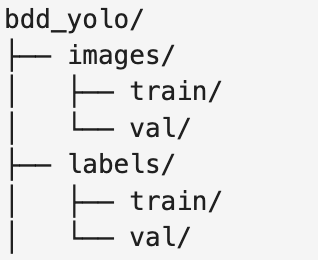
Copy matching images into images/train and images/val.  
Save converted .txt label files into labels/train and labels/val.

### Step 5: Random Sample

In [ ]:
# Define image and label folders
image_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/images/train'
label_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/labels/train'

# List all images and labels
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith('.txt')])

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Check matching names
image_basenames = set([os.path.splitext(f)[0] for f in image_files])
label_basenames = set([os.path.splitext(f)[0] for f in label_files])

# Find images without labels
images_without_labels = image_basenames - label_basenames
labels_without_images = label_basenames - image_basenames

print(f"Images without matching labels: {len(images_without_labels)}")
print(f"Labels without matching images: {len(labels_without_images)}")

# Optionally, list a few missing ones
if images_without_labels:
    print("Example images without labels:", list(images_without_labels)[:5])

if labels_without_images:
    print("Example labels without images:", list(labels_without_images)[:5])

In [ ]:
import os
import random
import shutil

# Set random seed
random.seed(42)

# Original folders
label_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/labels/train'
image_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/images/train'

# New folders
sampled_label_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/labels/sample_train'
sampled_image_folder = '/Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/images/sample_train'

os.makedirs(sampled_label_folder, exist_ok=True)
os.makedirs(sampled_image_folder, exist_ok=True)

# Step 1: List all labels
label_files = [f for f in os.listdir(label_folder) if f.endswith('.txt')]

# Step 2: Randomly sample 70% labels
sampled_label_files = random.sample(label_files, int(0.7 * len(label_files)))

# Step 3: Copy sampled labels
for label_file in sampled_label_files:
    src_label_path = os.path.join(label_folder, label_file)
    dst_label_path = os.path.join(sampled_label_folder, label_file)
    shutil.copy(src_label_path, dst_label_path)

# Step 4: Copy corresponding images
for label_file in sampled_label_files:
    img_file = label_file.replace('.txt', '.jpg')
    src_img_path = os.path.join(image_folder, img_file)
    dst_img_path = os.path.join(sampled_image_folder, img_file)
    
    if os.path.exists(src_img_path):
        shutil.copy(src_img_path, dst_img_path)
    else:
        print(f"Warning: Image {img_file} not found for label {label_file}")

print(f"Sampled {len(sampled_label_files)} labels and images.")

### Step 5: Prepare YOLOv11.  
Create a data.yaml file with:  
- Number of classes
- Class names
- Paths to train and val folders  
Install dependencies and test setup.

In [ ]:
%%writefile data.yaml
train: /Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/images/sample_train
val: /Users/christinadong/Documents/HERE Capstone/Data/bdd_yolo/images/val

nc: 6
names:
  - car
  - traffic light
  - traffic sign
  - bus
  - truck
  - other vehicle

### Step 6: Train YOLOv11 Model
Use the YOLOv11 training script   
Monitor training metrics (loss, mAP).  
Save and evaluate trained model.

In [ ]:
pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
model.train(
    data="/Users/christinadong/Documents/HERE Capstone/data.yaml",
    epochs=5,
    imgsz=640,
    batch=16,
    name="bdd_yolo8"
)